In [9]:
linesCodeAnalyzer = None
with open('CodeJamCrawler/dataset_csvs/code_analyzer_out_sorted.csv', 'r') as f:
    linesCodeAnalyzer = f.readlines()
    
codeAnalyzerHeader = linesCodeAnalyzer[0]
linesCodeAnalyzer = linesCodeAnalyzer[1:]

linesCccc = None
with open('CodeJamCrawler/dataset_csvs/cccc_cleared.csv', 'r') as f:
    linesCccc = f.readlines()
    
ccccHeader = linesCccc[0]
linesCccc = linesCccc[1:]

print (linesCodeAnalyzer[0])
print (linesCccc[0])

0.0_14_16505_55.cpp,1,49,13,47,0,2,23.50,0.00,23.50,0.96,47,0,2

0.0_14_16505_55.csv;1;43;43.000;12;12.000;0;0.000;******;******;0;0.000;0;0.000;0;0.000;3



In [10]:
def get_file_name(line, splitter):
    entries = line.split(splitter)
    file_name = entries[0][0:-4]
    return file_name

In [11]:
print (get_file_name(linesCodeAnalyzer[0], ','))
print (get_file_name(linesCccc[0], ';'))

0.0_14_16505_55
0.0_14_16505_55


In [12]:
# removing all the entries that aren't existing in outputCleared
cpp_files_only = []
for i in range(len(linesCodeAnalyzer)):
    if i % 1000 == 0:
        print (i)
        
    other = linesCodeAnalyzer[i]
    file_name_other = get_file_name(other, ',')
    
    found = False
    for cleared in linesCccc:
        file_name_cleared = get_file_name(cleared, ';')
        if file_name_cleared == file_name_other:
            found = True
            break
    if not found:
        continue
    cpp_files_only.append(file_name_other)
    
print ("Number of cpp files:", len(cpp_files_only))

0
1000
2000


KeyboardInterrupt: 

In [ ]:
print (cpp_files_only[0])

In [ ]:
print ('Code analyzer output:', codeAnalyzerHeader)
print ('CCCC analyzer output:', ccccHeader)

In [ ]:
import numpy as np

def parse_cccc(cccc_line):
    name = get_file_name(cccc_line, ';')
    res = name.split('_')[-1]
    author = name.split('_')[0]
    features = []
    for num in cccc_line.split(';')[1:]:
        if num == '******' or num == '------':
            num = '0.0'
        try:
            features.append(float(num))
        except ValueError:
            print (num)
            break
    return author, features, res


In [ ]:
def parse_code_analyzer(code_anal_line):
    name = get_file_name(code_anal_line, ',')
    res = name.split('_')[-1]
    author = name.split('_')[0]
    features = []
    for num in code_anal_line.split(',')[1:]:
        try:
            features.append(float(num))
        except ValueError:
            print (num)
            break
    return author, features, res

In [ ]:
print ('cccc line vec', parse_cccc(linesCccc[0]))
print ('code line vec', parse_code_analyzer(linesCodeAnalyzer[0]))

In [ ]:
cpp_files_map = set()

for n in cpp_files_only:
    cpp_files_map.add(n.split('_')[0])

src_vec_map = {}

for cccc_line in linesCccc:
    name, features, res = parse_cccc(cccc_line)
    if name not in src_vec_map:
        src_vec_map[name] = [(features,res)]
    else:
        src_vec_map[name].append((features, res))

for code_anal_line in linesCodeAnalyzer:
    name, features, res = parse_code_analyzer(code_anal_line)
    if name in cpp_files_map:
        src_vec_map[name].append((features, res))

In [ ]:
print (len(src_vec_map["4TShirt"]))
for v in src_vec_map["4TShirt"] :
    print (v)

In [ ]:
print (len(src_vec_map))
csvs_count = 0
for k in src_vec_map:
    csvs_count += len(src_vec_map[k])
    
print ("Number of csvs: ", csvs_count)

In [ ]:
import random
def load_dataset(src_vec_map):
    dataset_list = []
    
    for k in src_vec_map:
        i = 0
        half_list = int(len(src_vec_map[k])/2)
        
        while i < half_list :
            label = src_vec_map[k][i][1]
            #print(label)
            l1 = np.asarray(src_vec_map[k][i][0])
            l2 = np.asarray(src_vec_map[k][i+half_list][0])
            #print (l1.shape, l2.shape)
            l = np.concatenate((l1, l2), axis=0)
            i += 1
            
            # pojma nemam zašto se ovo događa - goran
            if l.size != 29:
                continue
            dataset_list.append((l, (k, label)))
            
    dataset = np.array(dataset_list)
    dataset = dataset.reshape((dataset.shape[0], dataset.shape[1]))
    return dataset

In [ ]:
dataset = load_dataset(src_vec_map)
print (dataset.shape, "NOTE : first dimension should be same as 18788/2\n\n")
print (dataset[0][1])

In [ ]:
def get_author_features_and_scores(author_name, dataset):
    codes = []
    scores = []
    
    for item in dataset:
        if item[1][0] == author_name:
            codes.append(item[0])
            scores.append(item[1][1])
            
    return (codes, scores)  

def create_correct_np_array(data_list):
    arr = np.array([])
    arr = np.hstack((arr, np.array(data_list[0])))

    for i in range(1, len(data_list)):
        arr = np.vstack((arr, np.array(data_list[i])))
        
    return arr

In [ ]:
# training and test authors, cca 70-30 omjer
author_names = list(src_vec_map.keys())

train_authors = author_names[0:1300]
test_authors = author_names[1300:]

print(len(train_authors))
print(len(test_authors))

X_train_list = []
y_train_list = []
X_test_list = []
y_test_list = []

for author in train_authors:
    codes, scores = get_author_features_and_scores(author, dataset)
    X_train_list.extend(codes)
    y_train_list.extend(scores)
    
for author in test_authors:
    codes, scores = get_author_features_and_scores(author, dataset)
    X_test_list.extend(codes)
    y_test_list.extend(scores)

In [ ]:
# iz nekog razloga svi ovi kodovi imaju više značajki nego što bi trebali
print("X_TRAIN\n")
for i in range(1, len(X_train_list)):
    if len (X_train_list[i]) != 29:
        print (i, "Broj značajki:", len (X_train_list[i]))

print("\nX_TEST\n")
for i in range(1, len(X_train_list)):
    if len (X_train_list[i]) != 29:
        print (i, "Broj značajki:", len (X_train_list[i]))

In [ ]:
X_train = create_correct_np_array(X_train_list)
X_test = create_correct_np_array(X_test_list)
y_train = create_correct_np_array(y_train_list)
y_test = create_correct_np_array(y_test_list)

print (X_train.shape)
print (X_test.shape)
print (y_train.shape)
print (y_test.shape)


In [ ]:
print (codeAnalyzerHeader.split(',')[1:-1], "\n")
print (ccccHeader.split(';')[1:], "\n")

labels = ccccHeader.split(';')[1:] + codeAnalyzerHeader.split(',')[1:-1]

print (len(labels))

In [ ]:
print (X_train.shape)

In [ ]:
def enlist_kept_cols(X, labels):
    
    cnt_cols = X.shape[1]
    X_reduced = []
    #labels_reduced = []
    kept_cols = []
    
    for i in range(cnt_cols):
        col = X[:,i]
        notInside = True
        for j in range(len(X_reduced)):
            if (col == X_reduced[j]).all():
                notInside = False
        
        if notInside:
            kept_cols.append(i)
            #labels_reduced.append(labels[i])
            X_reduced.append(col)

    #return np.array(X_reduced).T, labels_reduced, kept_cols
    return kept_cols

#X, labels_reduced = remove_same_cols(X, labels)
# decision on which column will be kept or not is made on training part because it is bigger
kept_cols = enlist_kept_cols(X_train, labels)
print (kept_cols)
X_train_reduced = X_train[:, kept_cols]
print (X_train_reduced.shape)
X_test_reduced = X_test[:, kept_cols]
print (X_test_reduced.shape)
labels_reduced = [labels[i] for i in kept_cols]
print (labels_reduced)

In [ ]:
import json
def create_json(author_names, dataset):
    data = {}
    data["column_descriptors"] = labels_reduced
    data["author_data"] = {}
    for author in author_names:
        feature_vecs, scores = get_author_features_and_scores(author, dataset)
        if len(scores) == 0:
            continue
        feat_vecs = [fv[kept_cols].tolist() for fv in feature_vecs]
        author_data = {}
        author_data["feature_vecs"] = feat_vecs
        author_data["scores"] = scores
        data["author_data"][author] = author_data
        
    with open('dataset.json', 'w') as outfile:
        json.dump(data, outfile)

#print get_author_features_and_scores(author_names[15], dataset)[1]
create_json(author_names, dataset)

In [1]:
import json
import numpy as np
def load_json():
    
    authors = []
    features = []
    scores = []
    
    with open('dataset.json') as data_file:
        data = json.load(data_file)
        labels = data["column_descriptors"]
        author_data = data["author_data"]
        
        for author in author_data.keys():
            authors.append(author)
            features.append(author_data[author]['feature_vecs'])
            scores_str = author_data[author]['scores']
            scores.append(np.asarray([int(score_) for score_ in scores_str]))
    
    # features to numpy array
    features = [np.asarray(feature) for feature in features]
    
    return labels, authors, features, scores

In [2]:
labels, authors, features, scores = load_json()
print (authors[0], features[0].shape, scores[0].shape)
print (labels)

(u'Faisal47', (3, 26), (3,))
[u'number_of_modules', u'lines_of_code', u'lines_of_code_per_module', u'McCabes_cyclomatic_complexity', u'McCabes_cyclomatic_complexity_per_module', u'lines_of_comment', u'lines_of_comment_per_module', u'lines_of_code_per_line_of_comment', u'McCabes_cyclomatic_complexity_per_line_of_comment', u'IF4', u'IF4_per_module', u'IF4_visible', u'IF4_visible_per_module', u'IF4_concrete', u'IF4_concrete', u'rejected_lines_of_code\n', u'Files', u'Lines', u'AVG Len', u'Code', u'Comments', u'White SP', u'Cd/Cm+WS', u'Cd/Cm', u'Cd/WS', u'% Code']


In [3]:
# training and test split
import random
cnt_train = 0.7 * len(authors)

train_authors_indices = set()

while len(train_authors_indices) < cnt_train:
    train_authors_indices.add(random.randint(0, len(authors) - 1))
    
test_authors_indices = set()

for i in range(len(authors)):
    if i not in train_authors_indices:
        test_authors_indices.add(i)

train_authors = [authors[i] for i in train_authors_indices]
        
test_authors = [authors[i] for i in test_authors_indices]

print(len(train_authors))
print(len(test_authors))

1095
469


In [4]:
X_train_list = []
y_train_list = []
X_test_list = []
y_test_list = []

X_list =[]
y_list = []

for index in range(len(authors)):
    X_list.extend(features[index])
    y_list.extend(scores[index])

for index in train_authors_indices:
    X_train_list.extend(features[index])
    y_train_list.extend(scores[index])
    
for index in test_authors_indices:
    X_test_list.extend(features[index])
    y_test_list.extend(scores[index])

X_train = np.asarray(X_train_list)
y_train = np.asarray(y_train_list)
X_test = np.asarray(X_test_list)
y_test = np.asarray(y_test_list)
X = np.asarray(X_list)
y = np.asarray(y_list)

print (X_train.shape, y_train.shape, X_test.shape, y_test.shape)

((12300, 26), (12300,), (5044, 26), (5044,))


In [5]:
import pandas as pd
#print 'labels', labels_reduced
print X.shape
df_before_feature_sel = pd.DataFrame(X)

(17344, 26)


In [6]:
print (df_before_feature_sel.columns)
print (len(labels))

RangeIndex(start=0, stop=26, step=1)
26


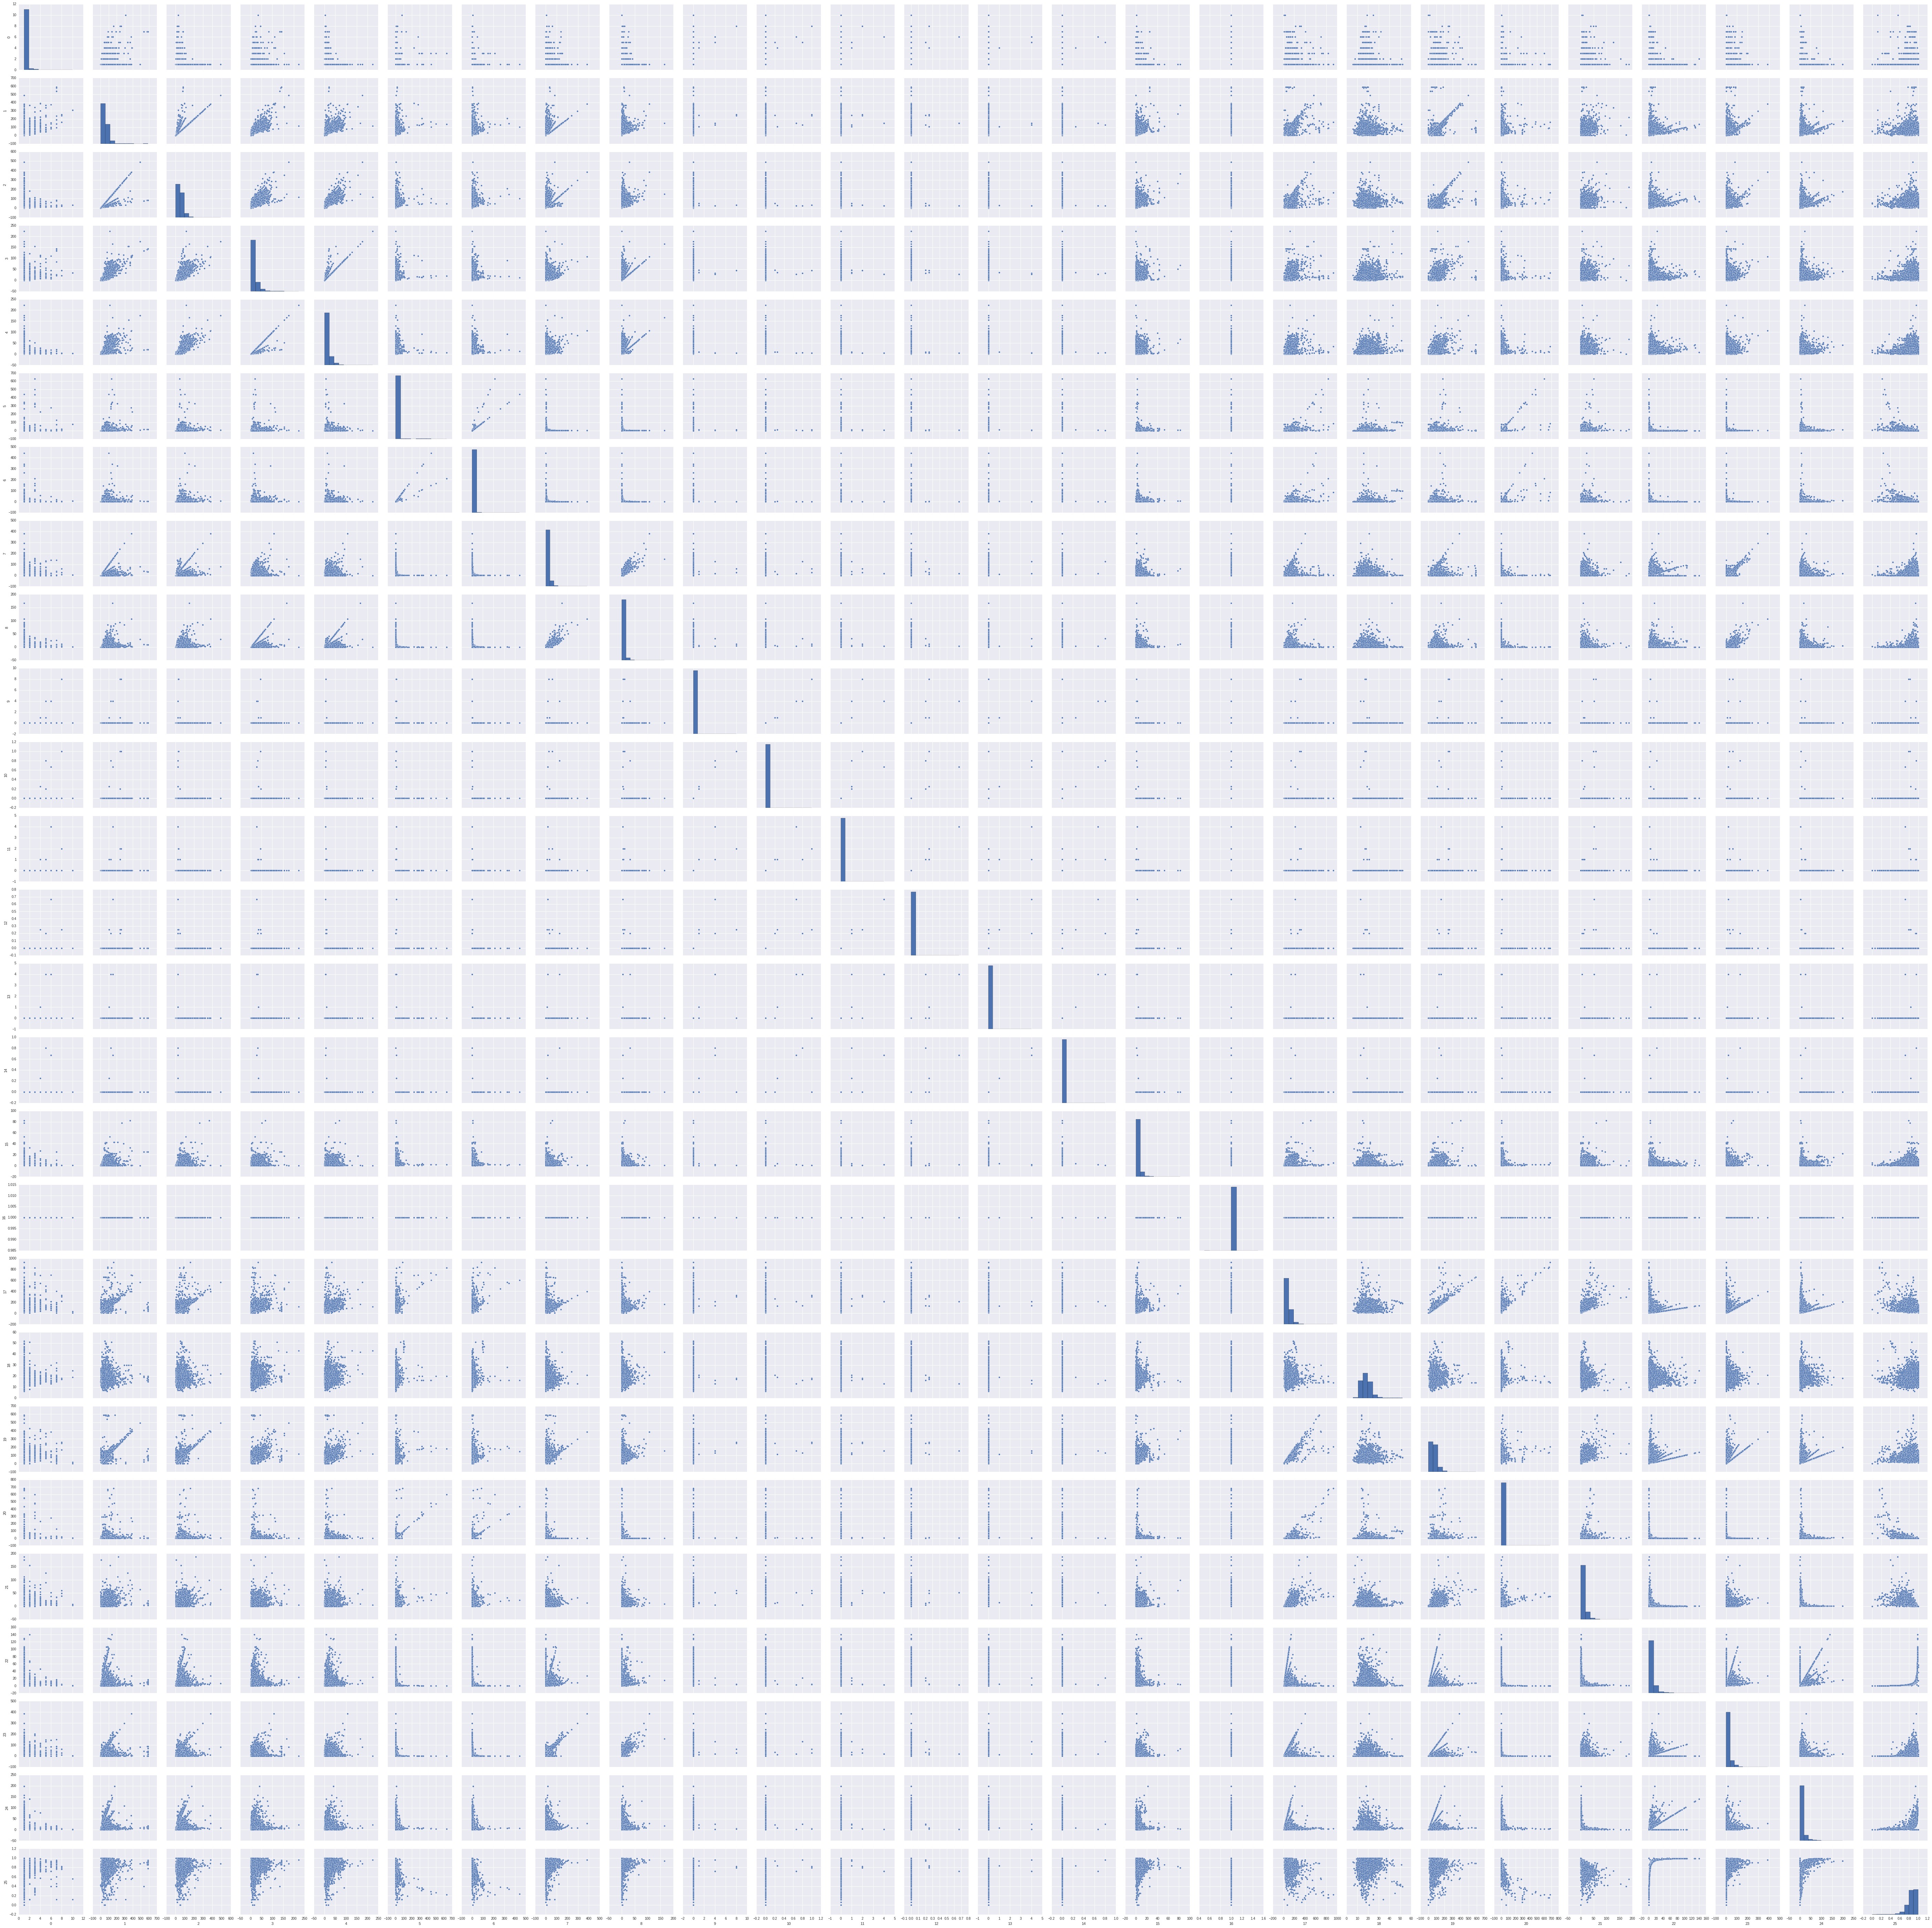

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.pairplot(df_before_feature_sel, size=3)
plt.show()

In [8]:
for i, label in enumerate(labels):
    print (i, label)

(0, u'number_of_modules')
(1, u'lines_of_code')
(2, u'lines_of_code_per_module')
(3, u'McCabes_cyclomatic_complexity')
(4, u'McCabes_cyclomatic_complexity_per_module')
(5, u'lines_of_comment')
(6, u'lines_of_comment_per_module')
(7, u'lines_of_code_per_line_of_comment')
(8, u'McCabes_cyclomatic_complexity_per_line_of_comment')
(9, u'IF4')
(10, u'IF4_per_module')
(11, u'IF4_visible')
(12, u'IF4_visible_per_module')
(13, u'IF4_concrete')
(14, u'IF4_concrete')
(15, u'rejected_lines_of_code\n')
(16, u'Files')
(17, u'Lines')
(18, u'AVG Len')
(19, u'Code')
(20, u'Comments')
(21, u'White SP')
(22, u'Cd/Cm+WS')
(23, u'Cd/Cm')
(24, u'Cd/WS')
(25, u'% Code')


In [9]:
df_descriptions = df_before_feature_sel.describe()
print (df_descriptions.T)

      count       mean        std  min      25%    50%     75%      max
0   17344.0   1.094154   0.534636  1.0   1.0000   1.00    1.00   10.000
1   17344.0  59.340752  43.815500  1.0  36.0000  50.00   71.00  587.000
2   17344.0  55.321522  32.591792  1.0  35.0000  48.00   68.00  488.000
3   17344.0  16.465175  15.112401  0.0   8.0000  13.00   20.00  223.000
4   17344.0  15.526430  13.329868  0.0   7.0000  12.00   19.00  223.000
5   17344.0   3.806677  16.187409  0.0   0.0000   1.00    3.00  631.000
6   17344.0   3.358194  10.928331  0.0   0.0000   0.50    3.00  441.000
7   17344.0  12.603457  21.715657  0.0   0.0000   0.00   17.50  382.000
8   17344.0   3.457977   7.142775  0.0   0.0000   0.00    4.00  166.000
9   17344.0   0.003921   0.149522  0.0   0.0000   0.00    0.00    8.000
10  17344.0   0.000606   0.021675  0.0   0.0000   0.00    0.00    1.000
11  17344.0   0.002191   0.082457  0.0   0.0000   0.00    0.00    4.000
12  17344.0   0.000363   0.013588  0.0   0.0000   0.00    0.00  